In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
#import statsmodels.api as sm
#import itertools as it
#from statsmodels.sandbox.stats.multicomp import multipletests
#from itertools import compress
from pyBedGraph import BedGraph
from pybedtools import BedTool
import scipy.stats

In [6]:
def read_cf(directory, file_name):
    with open(directory + file_name) as f:
        chrom = {}
        for line in f:
            tmp = line.strip().split("\t")
            if tmp[0] != 'chrM':
                chrom[tmp[0]] = int(tmp[1])
    return chrom

In [7]:
def read_peak(directory, file_name):
    with open(directory + file_name) as f:
        peak = []
        for line in f:
            tmp = line.strip().split("\t")
            peak.append([tmp[0], int(tmp[1]), int(tmp[2])])
    return peak

In [8]:
def plot_boxplot(dataset, dlabel, clr, tit, ylab, fig_name):
    fig = plt.figure(figsize = (8,6))
    medianprops = dict(linewidth = 3, color=clr)
    i=0
    boxprops = dict(linewidth = 1.5)
    toplot = [np.asarray([]) for i in range(len(dataset))]
    for d in dataset:
        #medianprops = dict(linewidth = 3, color=colcode[i])
        datax = toplot
        datax[i] = np.asarray(dataset[i])
        plt.boxplot(datax, widths = 0.6, medianprops = medianprops, boxprops = boxprops)
        i +=1
    plt.xticks([i for i in range(1, len(dataset)+1)], dlabel, fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.ylabel(ylab, fontsize = 18)
    #plt.ylim(bottom=2.5)
    plt.ylim(top=3.0)
    plt.title(tit, fontsize = 18)
    plt.savefig(fig_name+'.pdf', dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()

In [9]:
def get_cov(interval_list, bgobj):
    tmpvals = []
    for x in interval_list:
        if x[0] != 'chrM':
            value = list(bgobj.stats(stat = 'max', intervals = [x]))
            tmpvals.append(max(0, value[0]))
    return tmpvals

In [10]:
def write_result(directory, out_list, out_name):
    with open(directory+out_name, 'a') as file1:
        for i in range(len(out_list)):
            file1.write('\t'.join(map(str, out_list[i])) + '\n')
    file1.close()

In [15]:
directory='/Users/kimm/Desktop/GM12878_files/'
#ctcf_cov='CDH0002NR_hg38_CTCF_FDR_0.1_pseudoGEM_5000_enrichTest_master_PASS.bedgraph'
wapl_cov='CHG0032.q30.nr.sorted.bedgraph'
nipbl_cov='CHG0030.q30.nr.sorted.bedgraph'
reg1_file='GM12878-CTCF-pooled_thresh70_merge3kb_GM12878-cohesin-pooled_thresh400_merge3kb_common_peaks.bed'
reg3_file='GM12878-cohesin-pooled_thresh400_merge3kb_wo_GM12878-CTCF-pooled_thresh70_merge3kb_peaks.bed'
#anchor_peak='CHG0032_WAPL_overlap_CTCF_peaks_motif.bed'
#nonanchor_peak='CHG0032_WAPL_noCTCF_peaks_motif.bed'
#chromhmm_peak='CHG0032_WAPL_noCTCF_overlap_NIPBL_RNAPII_cohesin_chromHMMannot.bed'

In [12]:
chromfile = read_cf(directory, 'hg38.chrom.sizes')
#repet = BedTool(directory+'hg38PAM.sameChr.tx.sorted.legal.6To12Copies.within5kb_col1-4.bed')

In [13]:
bgwapl = BedGraph(directory+'hg38.chrom.sizes', directory+wapl_cov)

In [16]:
bgnipbl = BedGraph(directory+'hg38.chrom.sizes', directory+nipbl_cov)

In [17]:
for key,val in chromfile.items():
    bgwapl.load_chrom_data(key)
    bgnipbl.load_chrom_data(key)

In [19]:
reg1 = read_peak(directory, reg1_file)
reg3 = read_peak(directory, reg3_file)

In [20]:
reg1_wapl_vals = get_cov(reg1, bgwapl)
reg1_nipbl_vals = get_cov(reg1, bgnipbl)
reg3_wapl_vals = get_cov(reg3, bgwapl)
reg3_nipbl_vals = get_cov(reg3, bgnipbl)

In [58]:
x1 = [np.log10(x+1) for x in reg1_wapl_vals]
x2 = [np.log10(x+1) for x in reg3_wapl_vals]

In [59]:
anchr_stat = scipy.stats.mannwhitneyu(x1, x2)

In [60]:
anchr_title = "WAPL \n  Region1: median = " + str(int(np.median(reg1_wapl_vals))) + "; n = " + str(len(reg1_wapl_vals)) + "\n" + "region3: median = " + str(int(np.median(reg3_wapl_vals))) + "; n = " + str(len(reg3_wapl_vals)) + "\n" + "Mann-Whitney stat = " + str(anchr_stat[0]) + "; pval = " + str(anchr_stat[1]) 

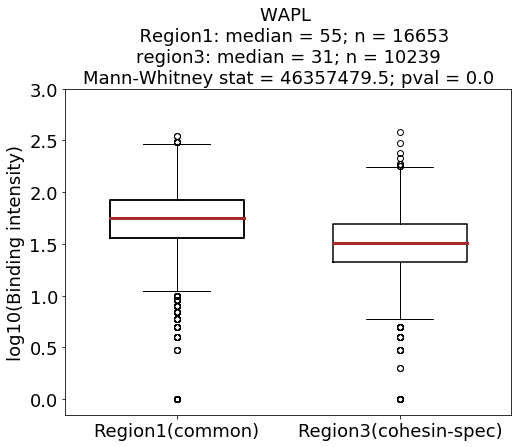

In [61]:
plot_boxplot([x1, x2], ['Region1(common)', 'Region3(cohesin-spec)'], 'brown', anchr_title, 'log10(Binding intensity)', 'wapl_reg1_vs_reg3_boxplot')

In [62]:
x1 = [np.log10(x+1) for x in reg1_nipbl_vals]
x2 = [np.log10(x+1) for x in reg3_nipbl_vals]

In [63]:
anchr_stat = scipy.stats.mannwhitneyu(x1, x2)

In [64]:
anchr_title = "NIPBL \n  Region1: median = " + str(int(np.median(reg1_nipbl_vals))) + "; n = " + str(len(reg1_nipbl_vals)) + "\n" + "region3: median = " + str(int(np.median(reg3_nipbl_vals))) + "; n = " + str(len(reg3_nipbl_vals)) + "\n" + "Mann-Whitney stat = " + str(anchr_stat[0]) + "; pval = " + str(anchr_stat[1]) 

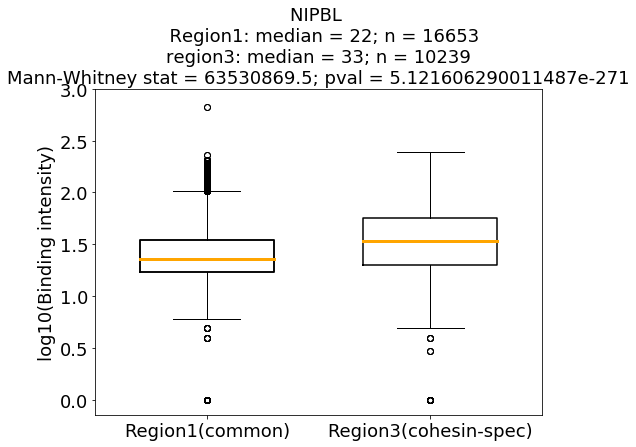

In [65]:
plot_boxplot([x1, x2], ['Region1(common)', 'Region3(cohesin-spec)'], 'orange', anchr_title, 'log10(Binding intensity)', 'nipbl_reg1_vs_reg3_boxplot')

In [66]:
n2w_reg1 = []
for i in range(len(reg1_wapl_vals)):
    nipbl = reg1_nipbl_vals[i]
    waplnorm = reg1_wapl_vals[i]*61848343/47004834
    ratio = nipbl/max(1,waplnorm)
    n2w_reg1.append(ratio)

In [67]:
n2w_reg3 = []
for i in range(len(reg3_wapl_vals)):
    nipbl = reg3_nipbl_vals[i]
    waplnorm = reg3_wapl_vals[i]*61848343/47004834
    ratio = nipbl/max(1,waplnorm)
    n2w_reg3.append(ratio)

In [68]:
x1 = n2w_reg1
x2 = n2w_reg3

In [69]:
anchr_stat = scipy.stats.mannwhitneyu(x1, x2)

In [70]:
anchr_title = "NIPBL/WAPL ratio \n  Region1: median = " + str(round(np.median(x1),4)) + "; n = " + str(len(x1)) + "\n" + "Region3: median = " + str(round(np.median(x2),4)) + "; n = " + str(len(x2)) + "\n" + "Mann-Whitney stat = " + str(anchr_stat[0]) + "; pval = " + str(anchr_stat[1]) 

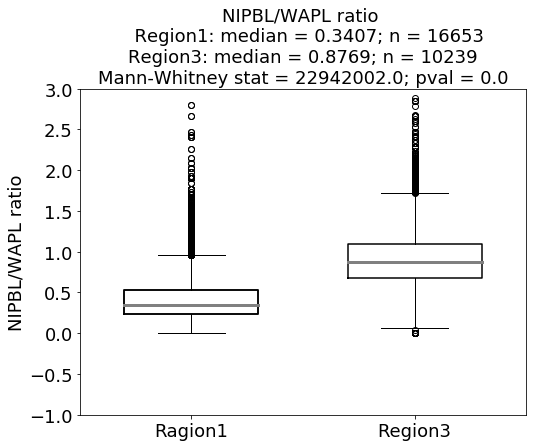

In [71]:
plot_boxplot([x1, x2], ['Ragion1', 'Region3'], 'grey', anchr_title, 'NIPBL/WAPL ratio', 'nipbl-wapl-ratio_reg1_vs_reg3_boxplot')